**Loading csv files from Google Drive. It is neccessary to have the two csv files in the MyDrive folder before performing this step.**

In [ ]:
import pandas as pd
import os
from google.colab import drive

def load_data():
    # Mount Google Drive
    drive.mount('/content/drive')

    # Define file paths
    credits_path = "/content/drive/MyDrive/tmdb_5000_credits.csv"
    movies_path = "/content/drive/MyDrive/tmdb_5000_movies.csv"

    # Verify if files exist
    if not (os.path.exists(credits_path) and os.path.exists(movies_path)):
        raise FileNotFoundError("Files not found. Check Google Drive paths!")

    print("✅ Files found! Loading data...")

    # Load datasets
    credits_df = pd.read_csv(credits_path)
    movies_df = pd.read_csv(movies_path)

    # Merge datasets on 'id' and 'movie_id'
    movies_df = movies_df.merge(credits_df, left_on='id', right_on='movie_id', how='left')

    return movies_df


**Data Preprocessing**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def preprocess_data(movies_df):
    # Select relevant numerical features and create a copy
    movies_df = movies_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']].copy()

    # Remove missing values
    movies_df.dropna(inplace=True)

    # Normalize numerical features
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(movies_df)

    # Convert each column explicitly to float32
    movies_df = pd.DataFrame(scaled_data, columns=movies_df.columns, dtype='float32')

    # Train-Validation-Test Split (80-10-10)
    train_df, temp_df = train_test_split(movies_df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    print(f"✅ Data Split: Train({len(train_df)}), Validation({len(val_df)}), Test({len(test_df)})")

    return train_df, val_df, test_df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Files found! Loading data...
🔍 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   obje

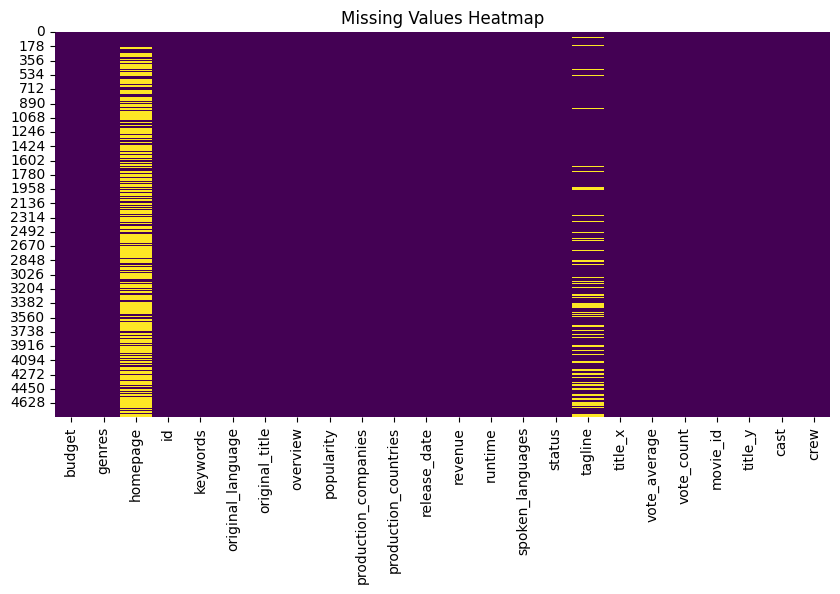

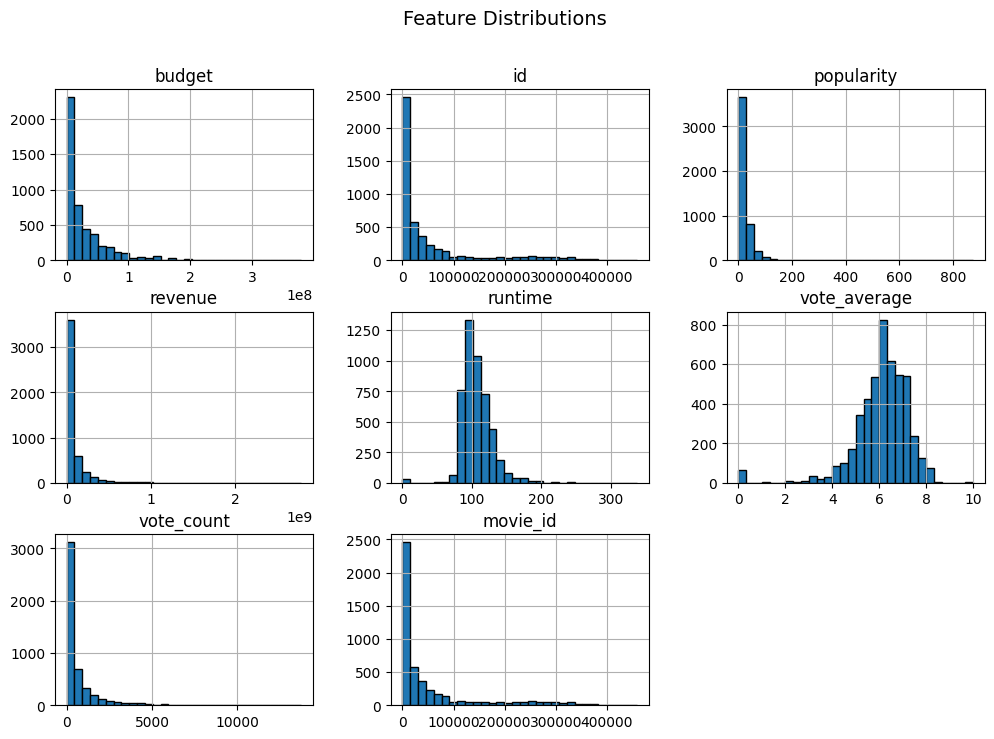

✅ Data Split: Train(3840), Validation(480), Test(481)

📊 Data after Preprocessing:
🔍 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 3840 entries, 2851 to 860
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   budget        3840 non-null   float32
 1   popularity    3840 non-null   float32
 2   revenue       3840 non-null   float32
 3   runtime       3840 non-null   float32
 4   vote_average  3840 non-null   float32
 5   vote_count    3840 non-null   float32
dtypes: float32(6)
memory usage: 120.0 KB
None

📊 Summary Statistics:
            budget   popularity      revenue      runtime  vote_average  \
count  3840.000000  3840.000000  3840.000000  3840.000000   3840.000000   
mean      0.074695     0.024295     0.028973     0.316254      0.609945   
std       0.104781     0.035408     0.058489     0.068817      0.119270   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25

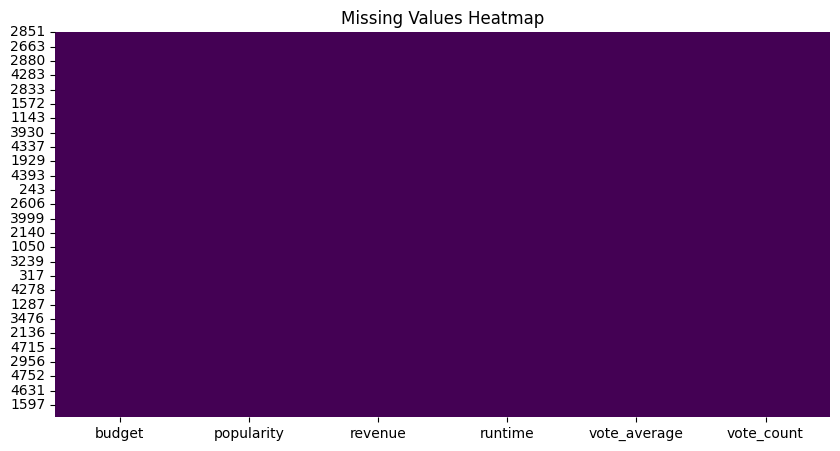

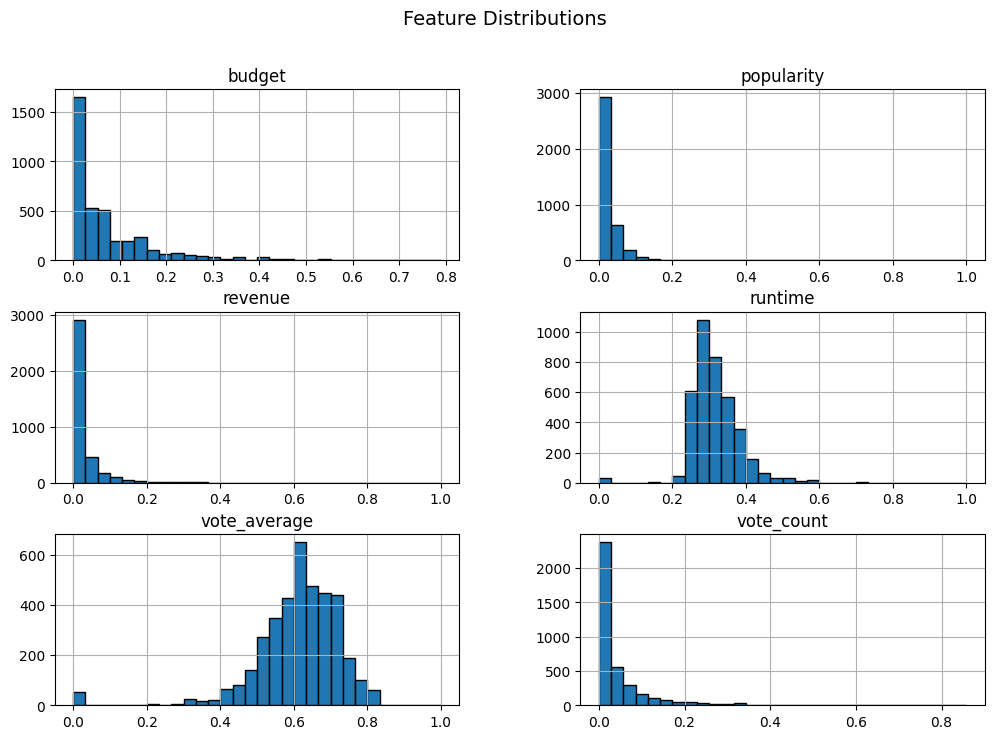

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_info(movies_df):
    # Display basic statistics
    print("🔍 Dataset Information:")
    print(movies_df.info())
    print("\n📊 Summary Statistics:")
    print(movies_df.describe())

    # Count missing values
    missing_values = movies_df.isnull().sum()
    print("\n❌ Missing Values per Column:")
    print(missing_values)

    # Unique values per column
    unique_values = movies_df.nunique()
    print("\n🔢 Unique Values per Column:")
    print(unique_values)

    # Plot missing values
    plt.figure(figsize=(10, 5))
    sns.heatmap(movies_df.isnull(), cbar=False, cmap="viridis")
    plt.title("Missing Values Heatmap")
    plt.show()

    # Plot distribution of numerical features
    movies_df.hist(figsize=(12, 8), bins=30, edgecolor="black")
    plt.suptitle("Feature Distributions", fontsize=14)
    plt.show()

# Call this function after loading the data
movies_df = load_data()

# Visualize data information before preprocessing
visualize_data_info(movies_df)

# Preprocess data
train_df, val_df, test_df = preprocess_data(movies_df)

# Visualize data after preprocessing
print("\n📊 Data after Preprocessing:")
visualize_data_info(train_df)


**Custom Dataset creation. Created a custom dataset as the dataset is not present in the torch.datasets library.
Also implemented the dataloader.**

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class MovieDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

def create_dataloaders(train_df, val_df, test_df, batch_size=32):
    # Create Dataset Instances
    train_dataset = MovieDataset(train_df)
    val_dataset = MovieDataset(val_df)
    test_dataset = MovieDataset(test_df)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
# Load data
movies_df = load_data()

# Preprocess data
train_df, val_df, test_df = preprocess_data(movies_df)

# Create DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(train_df, val_df, test_df)

# Verify DataLoader Output
for batch in train_loader:
    print(f"🛠 Train batch shape: {batch.shape}")  # Expected: (32, 6)
    break


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Files found! Loading data...
✅ Data Split: Train(3840), Validation(480), Test(481)
🛠 Train batch shape: torch.Size([32, 6])
